# Classifying Heart Disease in Patients using Multivariate 

# Introduction

#### Research question: Which physiological risk factors are most suitable for accurately classifying heart disease among patients?

Heart disease, also known as cardiovascular disease (CVD), is a major public health issue affecting millions of people worldwide. According to the Centers for Disease Control and Prevention (CDC), CVD is the leading cause of death globally, accounting for approximately 17.9 million deaths each year [3]. It includes a range of conditions that affect the heart and blood vessels, including coronary artery disease, heart failure, and stroke.

The prevalence of heart disease is on the rise, with several risk factors contributing to its development. These risk factors include high blood pressure, high cholesterol, obesity, physical inactivity, and smoking. These risk factors are increasingly common in the population, making heart disease a significant public health challenge.

This dataset from the UCI Machine Learning Repository contains 14 attributes (which have been subsetted from 76 attributes originally) collected from 303 patients by medical center in Cleveland. Similar to the published studies on this dataset, our project will select a subset of attributes from the given 14 to help in the classification of heart disease in a patient. The attributes we will consider include age, rest_bp (resting blood pressure), cholestrol, max_hr (max heart rate), and st_depr (ST depression). Since maximum heart rate and ST depression are two attributes that have been found to be especially useful in predicting heart disease in previous studies [1, 2], we predict that these two attributes will contribute the greatest in classifying presence of heart disease. We will use these attributes to train the program to be able to predict the presence of heart disease in new patients. 

![image.png](https://getmegiddy.com/sites/default/files/2021-02/Giddy_3d_P_Hero.gif)

# Methods and Results
For our data analysis, we will use tidymodel’s K-nearest neighbours to classify a patient as either having heart disease or not (yes for heart disease present, no for no heart disease present).

We plan on following the main data analysis workflow steps when designing a K-nearest neighbours model to ensure efficiency and clarity. After tidying the data, filtering out the unneeded columns, and scaling and centering the data, we will split the data into a training set and a testing set and use the training set for cross validation. Then, after analyzing the accuracies of various K values using a graph, we will choose the most optimal K value for our K-nearest neighbours model specification, recipe, and workflow.

The raw data contains thirteen columns that have the potential to act as predictors for the diagnosis of heart disease. In our data analysis, we will begin by only using five of these: age, rest_bp (resting blood pressure), cholestrol, max_hr (max heart rate), and st_depr (ST depression) and use forward selection to see which of these five attributes are most useful in predicting heart disease. We will then use these most relevant attributes to train the program to be able to predict the presence of heart disease in patients.

We will visualize the accuracy of each K value by creating a line plot depicting each K value and their respective accuracy. The plot of accuracy vs. number of neighbours will be used to choose the best K value. Additionally, we will visualize the final results by graphing all of the testing data on a scatter plot with each point coloured based on their predicted classification using our best classification model (one colour for yes, one for no).

### Loding the Libraries

> We will be loading several libraries: tidyverse, tidymodels, and repr. We will also be configuring some options for the plots here.

In [54]:
### Run this cell before continuing. 
library(tidyverse)
library(tidymodels)
library(repr)
options(repr.matrix.max.rows = 6)

### Wrangling and cleaning the data
> Now we load the heart data from the URL, provide column names, and change the appropriate variables from `<dbl>` to `<fct>` using `as.factor`. Finally, we will print and check the data to make sure it is tidy.

In [55]:
## Wrangling and cleaning the data
heart_data_url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
heart_cols <- c("age", "sex", "chest_pain_type", "rest_bp", "cholesterol", "fast_blood_sugar", "rest_ecg", "max_hr", "ex_angina", "st_depr", "slope_peak", "major_vessel_num", "thal", "pres_val")
heart_data <- read_csv(heart_data_url, col_names = heart_cols) |>
    mutate(sex = as.factor(sex),
          chest_pain_type = as.factor(chest_pain_type),
          fast_blood_sugar = as.factor(fast_blood_sugar),
          rest_ecg = as.factor(rest_ecg),
          ex_angina = as.factor(ex_angina),
          slope_peak = as.factor(slope_peak),
          major_vessel_num = as.factor(major_vessel_num),
          thal = as.factor(as.integer(thal)),
          pres_val = as.factor(pres_val),
          presence = as.factor(ifelse(pres_val == 0, "no", "yes")))
heart_data

Rows: 303 Columns: 14
-- Column specification --------------------------------------------------------
Delimiter: ","
chr  (2): major_vessel_num, thal
dbl (12): age, sex, chest_pain_type, rest_bp, cholesterol, fast_blood_sugar,...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
"There was 1 warning in `mutate()`.
i In argument: `thal = as.factor(as.integer(thal))`.
Caused by warning in `is.factor()`:
! NAs introduced by coercion"


age,sex,chest_pain_type,rest_bp,cholesterol,fast_blood_sugar,rest_ecg,max_hr,ex_angina,st_depr,slope_peak,major_vessel_num,thal,pres_val,presence
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6,0,no
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3,2,yes
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7,1,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7,3,yes
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3,1,yes
38,1,3,138,175,0,0,173,0,0.0,1,?,3,0,no


*Table 1: Wrangled and cleaned heart data*

### Splitting the Data
> We split the data into training and testing sets using the `initial_split()` function. We chose to allocate 75% of the data set to training and the other 25% of the data set to testing, ensuring that the data sets are balanced in terms of the number of patients with and without heart disease.

In [56]:
set.seed(1)
heart_split <- heart_data |>
    select(age, rest_bp, cholesterol, max_hr, st_depr, presence) |>
    initial_split(prop = 0.75, strata = presence)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

We then summarize the training data by counting the number observations of "yes" presence and "no" presence.

### Summarizing the Trainina Data

In [57]:
## Summarizing the training data (number of observations in each class)
heart_train_summary <- heart_train |>
    group_by(presence) |>
    summarize(count = n())
heart_train_summary

presence,count
<fct>,<int>
no,123
yes,104


*Table 2: Summary of number of observations that do and do not contain the presence of heart disease*

Since we want to get a better understanding of the chosen attributes in our training data, we then calculate the means of each predictor variable using the `colMeans()` function (first for those with heart disease and second for those without).

In [58]:
## Calculating means of the predictor variables in CVD positive cases
heart_train_predictors_mean_pos <- heart_train |>
    filter(presence == "yes") |>
    select(-presence) |>
    colMeans()

heart_train_predictors_mean_neg <- heart_train |>
    filter(presence == "no") |>
    select(-presence) |>
    colMeans()

heart_train_predictors_mean <- rbind(heart_train_predictors_mean_pos, heart_train_predictors_mean_neg) |>
    as_tibble() |>
    mutate(presence = c("yes", "no"))
heart_train_predictors_mean

age,rest_bp,cholesterol,max_hr,st_depr,presence
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
57.23077,135.5096,250.5673,138.2308,1.5442308,yes
52.96748,130.4553,243.9106,158.6748,0.6170732,no


*Table 3a: Means of each predictors in different CVD cases*

A brief summary of the means shows that patients with CVD generally have a higher resting blood pressure, higher cholesterol, lower maximum heart rate, and higher ST depression than those without CVD. This is consistent with previous studies that have found that patients with CVD tend to have higher resting blood pressure, higher cholesterol, and lower maximum heart rate [1, 2].

### Visualizing the Training Data
> Next, we visualize the training data by creating histogram distributions of each predictor column.

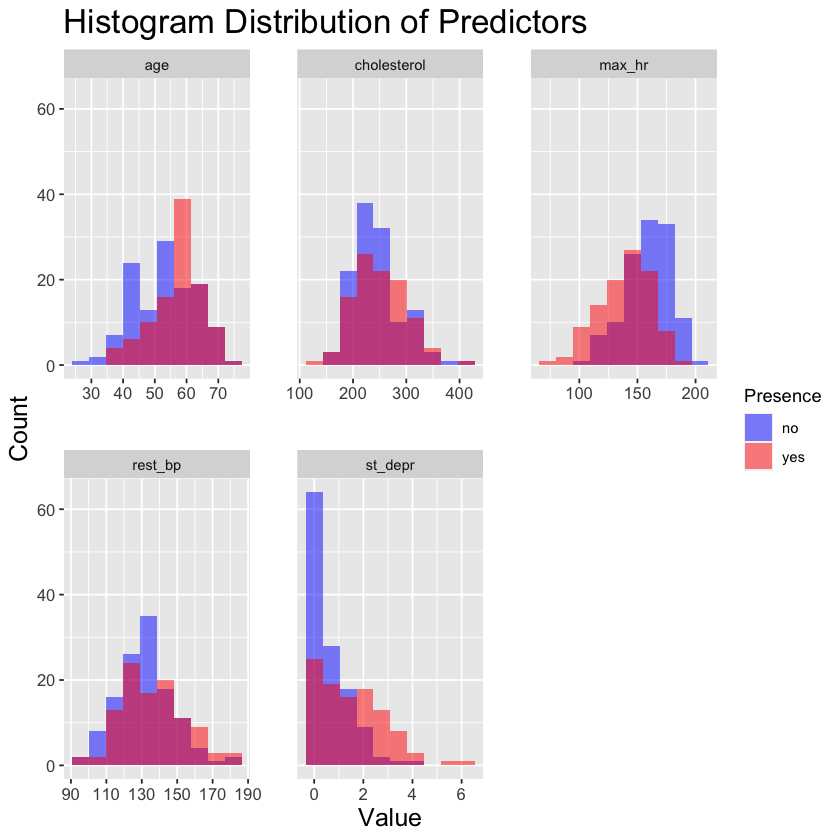

In [59]:
heart_train_long <- heart_train |>
pivot_longer(cols = -presence, names_to = "predictor", values_to = "value")

heart_train_predictor_plot <- heart_train_long |>
ggplot(aes(value, fill = presence)) +
geom_histogram(bins = 10, alpha = 0.5, position = "identity") +
facet_wrap(~predictor, scales = 'free_x') +
ggtitle("Histogram Distribution of Predictors") +
labs(y = "Count", x = "Value", fill = "Presence") +
scale_fill_manual(values = c("blue", "red")) +
theme(panel.spacing = unit(1, "cm")) +
theme(axis.title = element_text(size = 15)) +
theme(axis.text = element_text(size = 10)) +
theme(plot.title = element_text(size = 20))

heart_train_predictor_plot

### Analysis of Histogram
A histogram is a type of graph used to represent large amounts of numeric data, making it a suitable choice for this project given the large dataset.

Based on the histogram above, we can observe that the distribution of age in patients with CVD is slightly skewed to the right, indicating that the mean age of patients with CVD is slightly higher than the mean age of patients without CVD. This is consistent with previous studies that have found that patients with CVD tend to be older [1, 2]. Furthermore, the distribution of maximum heart rate in patients with CVD is slightly skewed to the left, indicating that the mean maximum heart rate of patients with CVD is slightly lower than the mean maximum heart rate of patients without CVD. We also see that the distribution of the other three predictors (resting blood pressure, cholesterol level, and ST depression measurement) in patients with CVD is fairly consistent with that of patients without CVD.

We then scale the data so that it is useable for KNN classification.

### KNN Classification
> In this project, we will be using the K-Nearest Neighbours(KNN) algorithm to predict the presence of the heart disease from the Cleveland Heart Disease dataset. We will create a recipe called heart_data_recipe that scale and center the predictors age, rest_bp, cholesterol, max_hr, and st_depr of the heart_data dataset. The resulting scaled and centered dataset is stored as heart_data_scaled.

In [60]:
heart_data_recipe <- recipe(presence ~ age + rest_bp + cholesterol + max_hr + st_depr, data = heart_data) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

heart_data_scaled <- heart_data_recipe |>
    prep() |>
    bake(heart_data)
heart_data_scaled

age,rest_bp,cholesterol,max_hr,st_depr,presence
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.9471596,0.7562740,-0.2644628,0.01716893,1.0855423,no
1.3897030,1.6085589,0.7591593,-1.81889638,0.3965257,yes
1.3897030,-0.6642009,-0.3417173,-0.90086373,1.3439235,yes
...,...,...,...,...,...
0.2833446,-0.09601098,-2.2344526,-1.512885,0.1381444,yes
0.2833446,-0.09601098,-0.2065219,1.066349,-0.8953805,yes
-1.8187363,0.35854099,-1.3846531,1.022633,-0.8953805,no


*Table 4: Scaled heart data*
> The above code is to create a recipe that defines the predictor variables and the outcome variable and also to `step_scale()` and `step_center()` all the predictor variables. Once the recipe is defined `prep()` and `bake()` are applied to the `heart_data`

### Finding the Optimal K and Forward Selection

We want to train and evaluate a k-nearest neighbors (KNN) model to predict the presence of heart disease in patients. We start by looking for the optimal K for our model. The preprocessed data is used to perform a 5-fold cross-validation to optimize the hyperparameters of the KNN model, which include the K number of neighbors to consider and the weight function to use. The accuracy of the model is evaluated for different values of k, and a plot is generated to visualize the relationship between k and accuracy. The optimal k value is then chosen based on the plot.

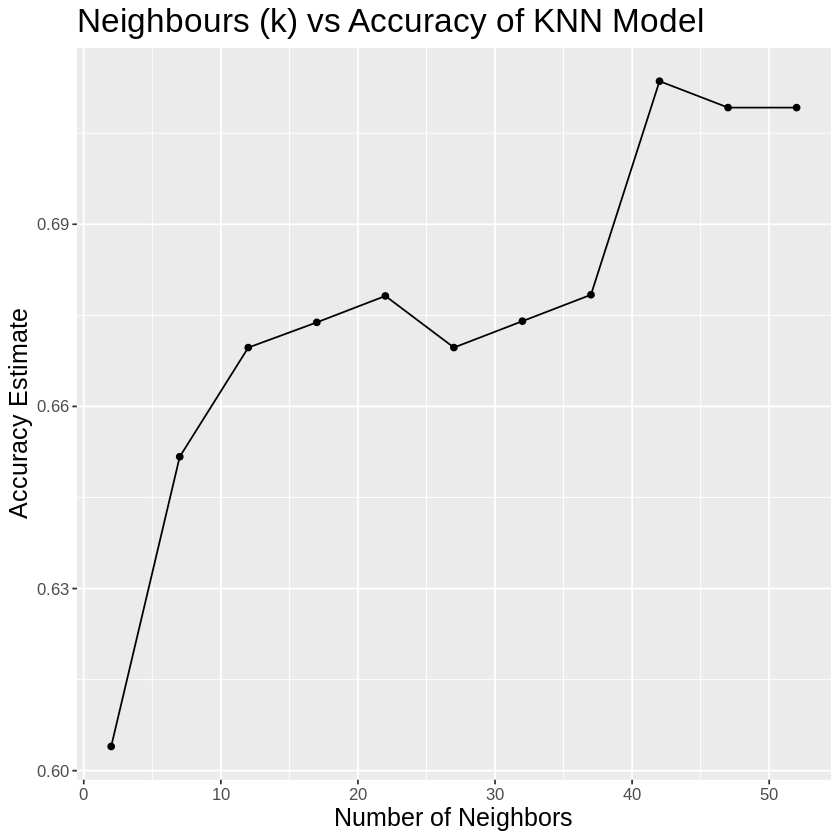

In [34]:
## Finding the optimal k value for the KNN model
knn_recipe <- recipe(presence ~ age + rest_bp + cholesterol + max_hr + st_depr, data = heart_train)

heart_train <- knn_recipe |>
    prep() |>
    bake(heart_train)

knn_vfold <- vfold_cv(heart_train, v = 5, strata = presence)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

k <- tibble(neighbors = seq(2, 52, 5))

knn_results <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = knn_vfold, grid = k) |>
    collect_metrics()

accuracies <- knn_results |>
    filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    ggtitle("Neighbours (k) vs Accuracy of KNN Model") +
    labs(x = "Number of Neighbors", y = "Accuracy Estimate") +
    theme(axis.title = element_text(size = 15)) +
    theme(axis.text = element_text(size = 10)) + 
    theme(plot.title = element_text(size = 20))

cross_val_plot

From the above code we are performing an hyperparameter tuning for KNN classification model using `heart_train` dataset.

We designed a recipe which defines the predictor variables and an outcome variable for the KNN model and then processed the `heart_train` dataset using this recipe.

We also created a 5 fold cross-validation object using `vfold_cv()`  to check the KNN model. And by using `tibble()` we created a dataframe specifying the range of k to test cross-validation, by using `workflow()` we defined the overall workflow of recipe, KNN model, also used `tune_grid()` to tune the hyperparameters over the specified range and resamples and `collect_metrics()` to collect metrics of parameters during cross-validation.

Finally, we plotted accuracy versus number of neighbors using ggplot2.

In [35]:
## Testing the model
knn_spec <- nearest_neighbor(weight = "rectangular", neighbor = 42) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_fit <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_spec) |>
    fit(data = heart_train)

knn_predictions <- predict(knn_fit, heart_test) |>
    bind_cols(heart_test)

knn_metrics <- knn_predictions |>
    metrics(truth = presence, estimate = .pred_class)

knn_conf_mat <- knn_predictions |>
    conf_mat(truth = presence, estimate = .pred_class)

knn_conf_mat

          Truth
Prediction no yes
       no  35  15
       yes  6  20

*Table 5: Confusion matrix*

Percent Accuracy of Model:

In [36]:
## Calculating percent accuracy of model
percent_accuracy <- (35 + 20) / (35 + 20 + 6 + 15)
percent_accuracy

[1] 0.7236842

**Forward Selection**

We implemented forward selection to determine what is the best number of prediction variables to ensure the highest prediction accuracy.

In [37]:
heart_train

predictors <- colnames(heart_train |> select(-presence))

predictors

formula <- paste("presence", "~", paste(predictors, collapse = "+"))

formula

age,rest_bp,cholesterol,max_hr,st_depr,presence
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,145,233,150,2.3,no
37,130,250,187,3.5,no
41,130,204,172,1.4,no
⋮,⋮,⋮,⋮,⋮,⋮
45,110,264,132,1.2,yes
68,144,193,141,3.4,yes
57,130,131,115,1.2,yes


[1] "age"         "rest_bp"     "cholesterol" "max_hr"      "st_depr"

[1] "presence ~ age+rest_bp+cholesterol+max_hr+st_depr"

**The code below was adapted from chapter 6.8.3 of the textbook.**

In [38]:
set.seed(100)

# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

# create a 5-fold cross-validation object
heart_vfold <- vfold_cv(heart_train, v = 5, strata = presence)

# store the total number of predictors
n_total <- length(predictors)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(predictors)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, predictors[[j]])
        model_string <- paste("presence", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        heart_recipe <- recipe(as.formula(model_string), 
                                data = heart_train) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe(heart_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = heart_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, predictors[[jstar]])
    predictors <- predictors[-jstar]
}
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,presence ~ st_depr,0.7135661
2,presence ~ st_depr+max_hr,0.7312516
3,presence ~ st_depr+max_hr+rest_bp,0.7226526
4,presence ~ st_depr+max_hr+rest_bp+age,0.7046728
5,presence ~ st_depr+max_hr+rest_bp+age+cholesterol,0.6825384


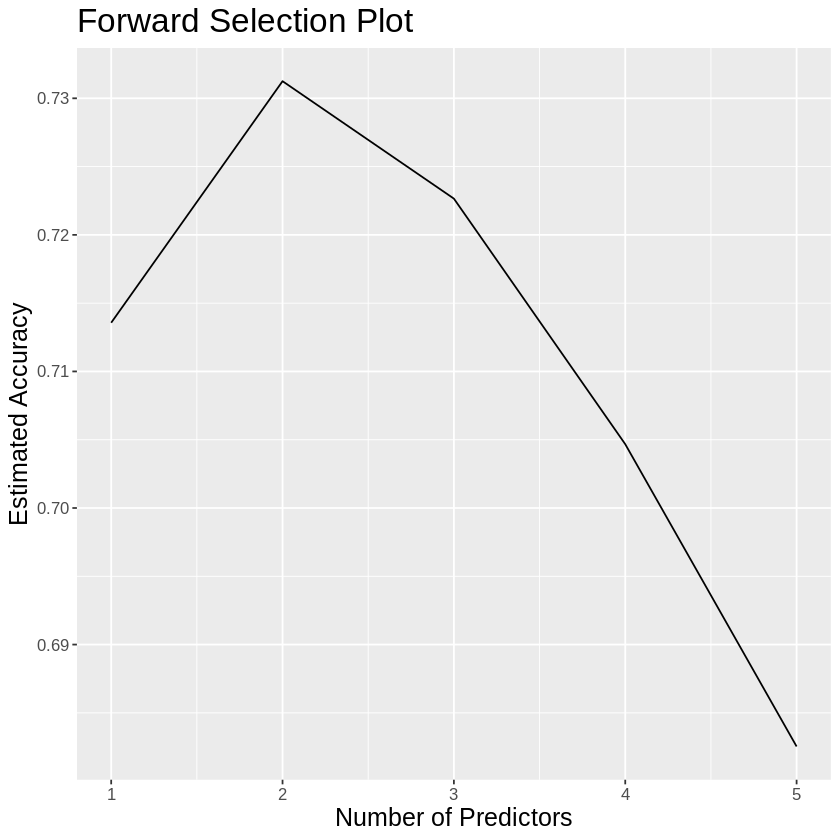

In [39]:
accuracy_plot <- ggplot(accuracies, aes(x = size, y = accuracy)) +
    geom_line() +
    labs(x = "Number of Predictors", y = "Estimated Accuracy") +
    ggtitle("Forward Selection Plot") +
    theme(axis.title = element_text(size = 15)) +
    theme(axis.text = element_text(size = 10)) + 
    theme(plot.title = element_text(size = 20))

accuracy_plot

.pred_class,age,rest_bp,cholesterol,max_hr,st_depr,presence
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
no,63,130,254,147,1.4,yes
no,57,140,192,148,0.4,no
no,56,130,256,142,0.6,yes
⋮,⋮,⋮,⋮,⋮,⋮,⋮
yes,59,164,176,90,1,yes
no,57,130,236,174,0,yes
no,38,138,175,173,0,no


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7631579


          Truth
Prediction no yes
       no  38  15
       yes  3  20

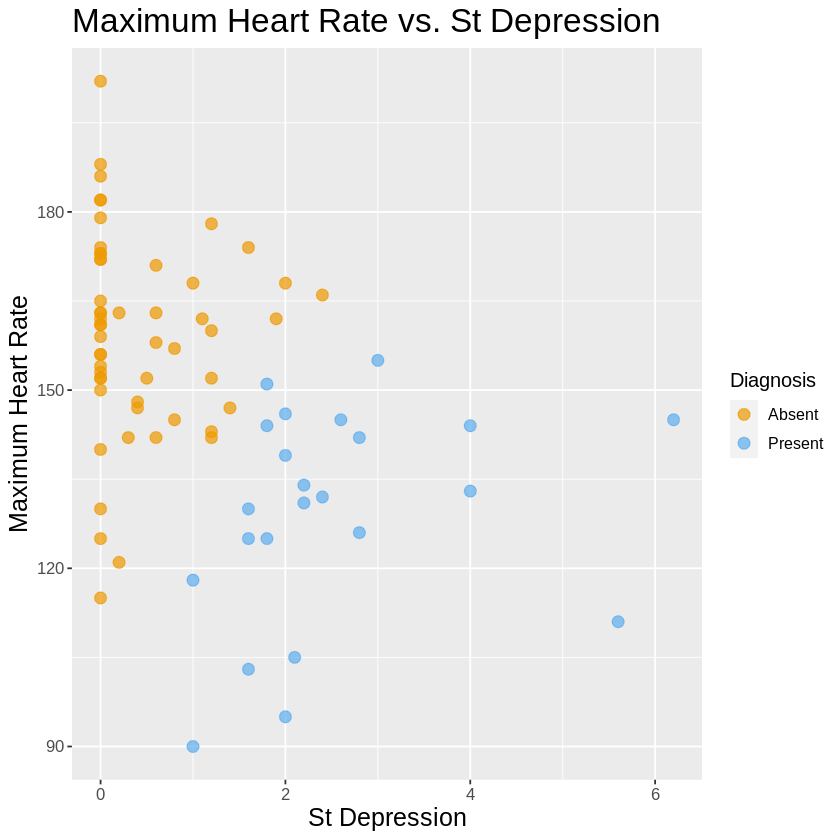

In [70]:
# Recipe.
heart_recipe_final <- recipe(presence ~ st_depr + max_hr, data = heart_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# Model specification.
heart_spec_final <- nearest_neighbor(weight_func = "rectangular", neighbors = 42) |>
    set_engine("kknn") |>
    set_mode("classification")

# Workflow.
heart_fit_final <- workflow() |>
    add_recipe(heart_recipe_final) |>
    add_model(heart_spec_final) |>
    fit(data = heart_train)

# Predictions.
heart_preds_final <- predict(heart_fit_final, heart_test) |>
    bind_cols(heart_test)
heart_preds_final

# Accuracy.
accuracy <- heart_preds_final |>
    metrics(truth = presence, estimate = .pred_class) |>
    filter(.metric == "accuracy")
accuracy

# Confusion matrix.
confusion <- heart_preds_final |>
    conf_mat(truth = presence, estimate = .pred_class)
confusion

# Scatterplot.
heart_plot <- ggplot(heart_preds_final, aes(x = st_depr, y = max_hr, color = .pred_class)) +
    geom_point(size = 3, alpha = 0.7) +
    labs(x = "St Depression", y = "Maximum Heart Rate", color = "Diagnosis") +
    scale_color_manual(labels = c("Absent", "Present"), values = c("orange2", "steelblue2")) + 
    ggtitle("Maximum Heart Rate vs. St Depression") +
    theme(text = element_text(size = 12)) +
    theme(axis.title = element_text(size = 15)) +
    theme(axis.text = element_text(size = 10)) + 
    theme(plot.title = element_text(size = 20))
heart_plot

# Discussion

Since heart disease can affect varying populations differently, we expect differences in the occurrence of heart disease among different age groups, genders, and collections of risk factors such as cholesterol and blood sugar in the development of the disease; furthermore, we expect that the greater one's age, resting blood pressure, serum cholesterol levels, maximum heart rate, and ST depression measurement, the greater the chance of that person being diagnosed with heart disease.

The findings of our project can be used to better understand the risk factors for heart disease by identifying populations that are most vulnerable to developing heart disease and recommending lifestyle changes to decrease the chances of developing heart disease, such as by developing better treatment plans suited for certain populations using personalized medicine. This project's findings can also be used for early screening, leading to healthcare professionals recognizing greater risk for heart disease and recommending patients take scanning tests to obtain more data for diagnosis.

Some of the future questions this project's findings could lead to include:
1. Are there any methods to enhance heart disease diagnostic and screening procedures to ensure earlier recognition and treatment?
2. How can healthcare professionals better inform the public about typical heart disease symptoms or warning signs to increase early detection?
3. For certain age groups or genders at greater risk of heart disease, are there particular interventions or treatment modalities that are more successful?
   

## References

1.  Davidovic G, Iric-Cupic V, Milanov S, Dimitijevic A, Petrovic-Janicijevic M. When heart goes "BOOM" to fast. Heart rate greater than 80 as mortality predictor in acute myocardial infarction. Am J Cardiovasc Dis. 2013 Aug 16;3(3):120-8. PMID: 23991346; PMCID: PMC3751677.

2.  Kashou AH, Basit H, Malik A. ST Segment. [Updated 2022 Aug 8]. In: StatPearls [Internet]. Treasure Island (FL): StatPearls Publishing; 2023 Jan-. Available from: https://www.ncbi.nlm.nih.gov/books/NBK459364/

3.  National Center for Chronic Disease Prevention and Health Promotion , Division for Heart Disease and Stroke Prevention. (2022, February 7). Heart Disease Facts. Retrieved March 10, 2022, from https://www.cdc.gov/heartdisease/facts.htm

4.  UCI Machine Learning Repository: Heart Disease Data Set. (2019). Uci.edu. https://archive.ics.uci.edu/ml/datasets/Heart+Disease